# Study of the relation between Entropy of the predictive and optimum scaling temperature

In [2]:
%load_ext autoreload

In [3]:
%autoreload 1

In [4]:
import os
import sys
import time
sys.path.extend(['..'])

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from scipy.stats import entropy
import torch
import torch.nn as nn
from torch.nn.functional import softplus

from scipy_models import TS, HTS
from scipy_models import HistTS
from models import AdaTS, PTS
from models import HTS as HTS_torch
%aimport utils
from utils import compare_results, calib_split, torch_entropy, binByEntropy, load_precomputedlogits, compute_metrics
%aimport adats_utils
from adats_utils import fitAdaTS

In [5]:
%matplotlib inline

In [6]:
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage{amssymb}')

In [7]:
color_palette_J = {
                     'black': '#000000',
                     'orange': '#E69F00',
                     'blue': '#56B4E9',
                     'green': '#009E73',
                     'yellow': '#F0E442',
                     'dark_blue': '#0072B2',
                     'dark_orange': '#D55E00',
                     'pink': '#CC79A7',
                     'white': '#111111',
                     'grey': 'grey'
                   }


## Load data RESNET50

In [8]:
CIFAR10_PATH = '../../data/CIFAR10'
MODEL_PATH = '../../trained_models/CIFAR10/resnet50'

In [9]:
np.random.seed(0)
Z_train = np.load(os.path.join(MODEL_PATH, 'train_logits.npy'))
Z_val = np.load(os.path.join(MODEL_PATH, 'val_logits.npy'))
Z_test = np.load(os.path.join(MODEL_PATH, 'test_logits.npy'))

y_train = np.load(os.path.join(CIFAR10_PATH, 'train_labels.npy'))
y_val = np.load(os.path.join(CIFAR10_PATH, 'val_labels.npy'))
y_test = np.load(os.path.join(CIFAR10_PATH, 'test_labels.npy'))

ix_ld = np.random.permutation(Z_val.shape[0])[:200]

In [10]:
N, dim = Z_train.shape

#### Train standard Temp-Scaling

In [11]:
### Temp-Scal as baseline:
tempScaler = TS(dim)
tempScaler.fit(Z_val, y_val, v=True);

Optimization terminated successfully.
         Current function value: 2171.642972
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8


#### Train Entropy Based Temp-Scaling

In [12]:
hts = HTS(dim)
hts.fit(Z_val, y_val, v=True)

         Current function value: 2152.374121
         Iterations: 11
         Function evaluations: 57
         Gradient evaluations: 51


In [13]:
hisTS = HistTS()
hisTS.fit(Z_val, y_val)

In [14]:
hts_t = AdaTS(HTS_torch(dim))
hts_t = fitAdaTS(hts_t, Z_val, y_val, epochs=30000, batch_size=10000, lr=1e-3, v=True)

On epoch: 6794, loss: 2.153e+03, at time: 39.54s
Finish training, convergence reached. Loss: 2153.18 



In [15]:
hts_tld = AdaTS(HTS_torch(dim))
hts_tld = fitAdaTS(hts_tld, Z_val[ix_ld], y_val[ix_ld], epochs=30000, lr=1e-3, v=True)

On epoch: 6624, loss: 9.735e+01, at time: 7.97s
Finish training, convergence reached. Loss: 97.35 



In [42]:
pts = AdaTS(PTS(dim))
pts = fitAdaTS(pts, torch.as_tensor(Z_val), torch.as_tensor(y_val), epochs=30000, batch_size=10000, lr=1e-3, v=True)

On epoch: 6054, loss: 2.150e+03, at time: 66.04s
Finish training, convergence reached. Loss: 2149.97 



In [18]:
ptsld = AdaTS(PTS(dim))
ptsld = fitAdaTS(ptsld, torch.as_tensor(Z_val[ix_ld]), torch.as_tensor(y_val[ix_ld]), epochs=30000, lr=1e-3, v=True)

On epoch: 8154, loss: 8.353e+01, at time: 15.58s
Finish training, convergence reached. Loss: 83.53 



In [43]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScaler.predictive(Z_train),
                             'HTS': hts.predictive(Z_train),
                             'HTS_torch': hts_t.predictive(Z_train),
                             'PTS': pts.predictive(Z_train),
                             'HTS_torch_ld': hts_tld.predictive(Z_train),
                             'PTS_ld': ptsld.predictive(Z_train),
                             'Entropy Histogram TS': hisTS.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
           Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                         99.94%         0.11%        45.80%    1.104e-03     2.701e-03
TempScal                      99.94%         5.35%        65.23%    8.604e-03     5.812e-02
HTS                           99.94%         4.79%        74.31%    9.582e-03     5.312e-02
HTS_torch                     99.94%         4.68%        73.94%    8.995e-03     5.174e-02
PTS                           99.94%         4.82%        74.21%    9.635e-03     5.346e-02
HTS_torch_ld                  99.94%         5.70%        40.37%    9.745e-03     6.217e-02
PTS_ld                        99.94%         6.30%        69.18%    1.824e-02     7.366e-02
Entropy Histogram TS          99.94%         4.82%        43.82%    1.043e-02     5.380e-02


In [44]:
print('##### Results on validation set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScaler.predictive(Z_val),
                             'HTS': hts.predictive(Z_val),
                             'HTS_torch': hts_t.predictive(Z_val),
                             'PTS': pts.predictive(Z_val),
                             'HTS_torch_ld': hts_tld.predictive(Z_val),
                             'PTS_ld': ptsld.predictive(Z_val),
                             'Entropy Histogram TS': hisTS.predictive(Z_val)}, target=y_val, from_logits=False);

##### Results on validation set:
           Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                         86.72%        10.30%        73.80%    2.300e-01     7.737e-01
TempScal                      86.72%         2.49%        55.51%    1.967e-01     4.343e-01
HTS                           86.72%         1.29%        80.79%    1.953e-01     4.305e-01
HTS_torch                     86.72%         1.30%        80.65%    1.955e-01     4.306e-01
PTS                           86.72%         1.10%        80.72%    1.951e-01     4.300e-01
HTS_torch_ld                  86.72%         2.04%        80.10%    1.959e-01     4.332e-01
PTS_ld                        86.72%         5.26%        11.90%    2.155e-01     8.653e-01
Entropy Histogram TS          86.72%         1.27%        31.97%    1.949e-01     4.290e-01


In [45]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScaler.predictive(Z_test),
                             'HTS': hts.predictive(Z_test),
                             'HTS_torch': hts_t.predictive(Z_test),
                             'PTS': pts.predictive(Z_test),
                             'HTS_torch_ld': hts_tld.predictive(Z_test),
                             'PTS_ld': ptsld.predictive(Z_test),
                             'Entropy Histogram TS': hisTS.predictive(Z_test)}, target=y_test, from_logits=False);

##### Results on test set:
           Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                         86.13%        10.69%        35.80%    2.392e-01     7.897e-01
TempScal                      86.13%         2.35%        16.93%    2.037e-01     4.473e-01
HTS                           86.13%         0.96%        15.98%    2.024e-01     4.448e-01
HTS_torch                     86.13%         1.22%        14.89%    2.026e-01     4.447e-01
PTS                           86.13%         1.05%        14.00%    2.023e-01     4.441e-01
HTS_torch_ld                  86.13%         1.86%        18.51%    2.029e-01     4.465e-01
PTS_ld                        86.13%         4.63%        17.59%    2.235e-01     8.131e-01
Entropy Histogram TS          86.13%         0.91%        22.35%    2.022e-01     4.451e-01


In [46]:
hts.b

3.070982955626601

In [47]:
hts.w

0.08824054990272831

In [48]:
hts_t.modelT.b

Parameter containing:
tensor([2.9945], requires_grad=True)

In [25]:
hts_t.modelT.w

Parameter containing:
tensor([0.0832], requires_grad=True)

## Fitted map $f(H) \mapsto T$

In [26]:
minH = 0
maxH = 1

x_axis = np.geomspace(minH+1e-8, maxH, 250)

In [27]:
lhb, lhw = hts.b, hts.w
lhb_t, lhw_t = hts_t.modelT.b.item(), hts_t.modelT.w.item()
lhb_tld, lhw_tld = hts_tld.modelT.b.item(), hts_tld.modelT.w.item()

def HTS2T(h):
    T = np.log(np.exp(np.log(h) * lhw + lhb) + 1)
    return T

def HTS2T_t(h):
    T = np.log(np.exp(np.log(h) * lhw_t + lhb_t) + 1)
    return T

def HTS2T_tld(h):
    T = np.log(np.exp(np.log(h) * lhw_tld + lhb_tld) + 1)
    return T

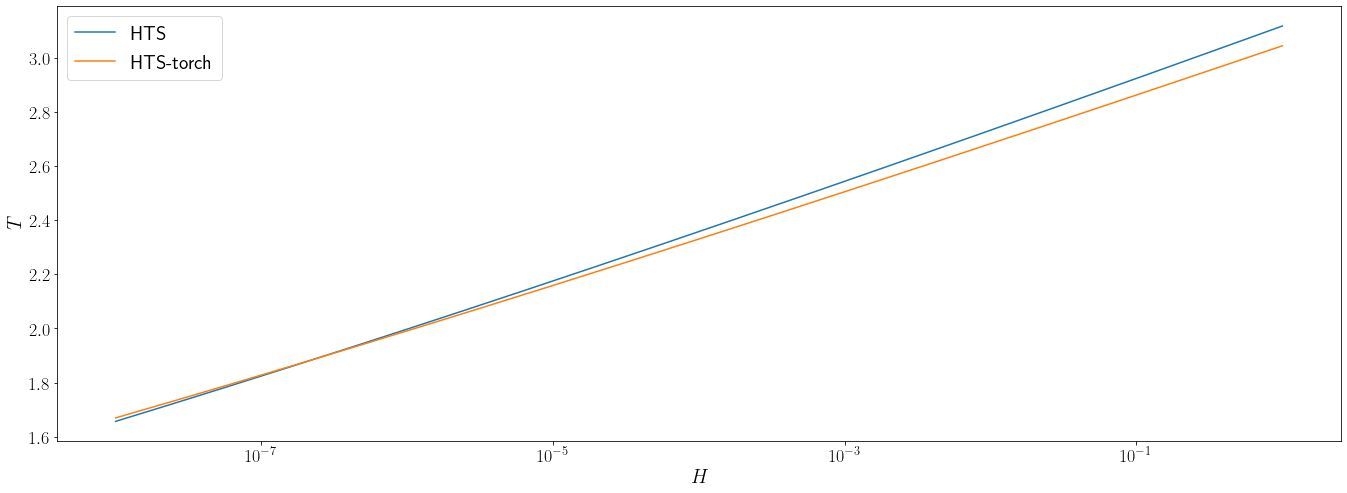

In [28]:
fig, ax = plt.subplots(figsize=(23, 8))

ax.plot(x_axis, HTS2T(x_axis), label='HTS')
ax.plot(x_axis, HTS2T_t(x_axis), label='HTS-torch')
ax.set_xlabel('$H$', fontsize=20)
ax.set_ylabel('$T$', fontsize=20)

ax.tick_params(axis='both', labelsize=18)
ax.set_xscale('log')
ax.legend(fontsize=20)

plt.plot();

### Estimate Optimum Temp vs Entropy

In [29]:
# Binarize Data
M = 15
ixs, lims = binByEntropy(Z_test, M=M, mode='log')

## Compute optimum entropy per bin
Ts = np.ones(M)
for i, ix in enumerate(ixs):
    if any(ix):
        try:
            ts_aux = TS(dim)
            ts_aux.fit(Z_test[ix], y_test[ix], v=False);
            Ts[i] = ts_aux.t
        except Exception as e:
            print(e)
            continue

### Pearson coefficient

In [30]:
def get_r(X, Y):
    X = X - np.mean(X)
    Y = Y - np.mean(Y)
    
    return np.sum(X*Y)/np.sqrt(np.sum(X**2)*np.sum(Y**2))

In [31]:
z_bins =  np.stack([np.mean(Z_test[ix], axis=0) for ix in ixs])

In [32]:
z_bins

array([[ 3.3052456 , -2.138935  ,  0.76210433, -2.1210926 ,  4.6977515 ,
        -1.3594763 , -1.1495432 , -2.090149  , -2.4150155 ,  2.508939  ],
       [ 3.0380383 , -1.6370724 ,  1.8162267 , -1.2274852 ,  1.6433564 ,
        -1.0645283 , -2.0163229 , -1.0029818 , -1.800242  ,  2.2475934 ],
       [ 2.100329  , -1.3938557 ,  0.535512  , -0.61578447,  0.9388032 ,
        -0.8594014 , -1.5940983 , -0.9233414 , -0.4810173 ,  2.2898324 ],
       [ 0.993081  , -0.869644  ,  0.38306952, -0.82841885,  0.16407238,
        -0.31040397, -1.025709  , -1.0649866 ,  1.0481739 ,  1.5060534 ],
       [ 0.46079656, -0.12488116,  0.34637353, -0.61240464, -0.30228505,
        -0.47428373, -0.19833723, -0.95483184,  0.9206998 ,  0.93366754],
       [-0.1783597 ,  0.38368854,  0.3134383 , -0.31909484, -0.27569345,
        -0.41677737,  0.02876376, -0.32032567,  0.17347422,  0.6049426 ],
       [-0.20772831,  0.54733497,  0.5641834 , -0.1776355 , -0.32128206,
        -0.59216917,  0.02709948,  0.3706564 

In [33]:
pts_bin = [np.mean(pts.get_T(Z_test[ix]).flatten()) for ix in ixs]
ptsld_bin = [np.mean(ptsld.get_T(Z_test[ix]).flatten()) for ix in ixs]

hts_t_bin = [np.mean(hts_t.get_T(Z_test[ix]).flatten()) for ix in ixs]
hts_tld_bin = [np.mean(hts_tld.get_T(Z_test[ix]).flatten()) for ix in ixs]

In [34]:
Ts

array([0.89921941, 0.77231969, 2.26093976, 2.03736324, 2.3388418 ,
       2.30951395, 2.34329206, 2.44544857, 2.66876095, 2.81006556,
       2.75609283, 2.92304004, 2.79067163, 2.69681231, 2.78585658])

In [35]:
pts_bin

[2.3476293,
 2.2512531,
 2.2041457,
 2.1778474,
 2.230176,
 2.3078015,
 2.398129,
 2.5037715,
 2.6182709,
 2.72391,
 2.831582,
 2.904936,
 2.9043255,
 2.8151488,
 2.659086]

In [36]:
print("Sample Pearson correlation coefficient for PTS with all data is {:.4f}".format(get_r(Ts[1:], pts_bin[1:])))
print("Sample Pearson correlation coefficient for PTS with low data is {:.4f}".format(get_r(Ts[1:], ptsld_bin[1:])))
print("Sample Pearson correlation coefficient for HTS with all data is {:.4f}".format(get_r(Ts[1:], hts_t_bin[1:])))
print("Sample Pearson correlation coefficient for HTS with low data is {:.4f}".format(get_r(Ts[1:], hts_tld_bin[1:])))

Sample Pearson correlation coefficient for PTS with all data is 0.6994
Sample Pearson correlation coefficient for PTS with low data is 0.8033
Sample Pearson correlation coefficient for HTS with all data is 0.6263
Sample Pearson correlation coefficient for HTS with low data is 0.6279


In [37]:
from itertools import product as iter_product

In [70]:
get_r(pts.get_T(Z_test).flatten(), hts_t.get_T(Z_test).flatten())

0.8902508

In [71]:
get_r(pts.get_T(Z_test).flatten(), hts_tld.get_T(Z_test).flatten())

0.8905953

In [72]:
get_r(pts.get_T(Z_test).flatten(), ptsld.get_T(Z_test).flatten())

0.19945085

In [53]:
Ts

array([0.89921941, 0.77231969, 2.26093976, 2.03736324, 2.3388418 ,
       2.30951395, 2.34329206, 2.44544857, 2.66876095, 2.81006556,
       2.75609283, 2.92304004, 2.79067163, 2.69681231, 2.78585658])

In [54]:
ptsld_bin

[0.6830847,
 0.91088223,
 1.0650525,
 1.264896,
 1.4099752,
 1.5433491,
 1.685948,
 1.9688377,
 2.1211712,
 2.285465,
 2.4666536,
 2.4263592,
 2.5070465,
 2.671273,
 2.0358074]

In [55]:
logH_test = entropy(softmax(Z_test, axis=1), axis=1)/np.log(10)
ix = np.argsort(logH_test)
logH_test = logH_test[ix]
sorted_test = Z_test[ix]

pts_test = pts.get_T(sorted_test).flatten()
ptsld_test = ptsld.get_T(sorted_test).flatten()

hts_t_test = hts_t.get_T(sorted_test).flatten()
hts_tld_test = hts_tld.get_T(sorted_test).flatten()

In [56]:
logH_test

array([1.4394598e-07, 1.7075986e-07, 1.7169666e-07, ..., 6.2903696e-01,
       6.3004190e-01, 6.4332938e-01], dtype=float32)

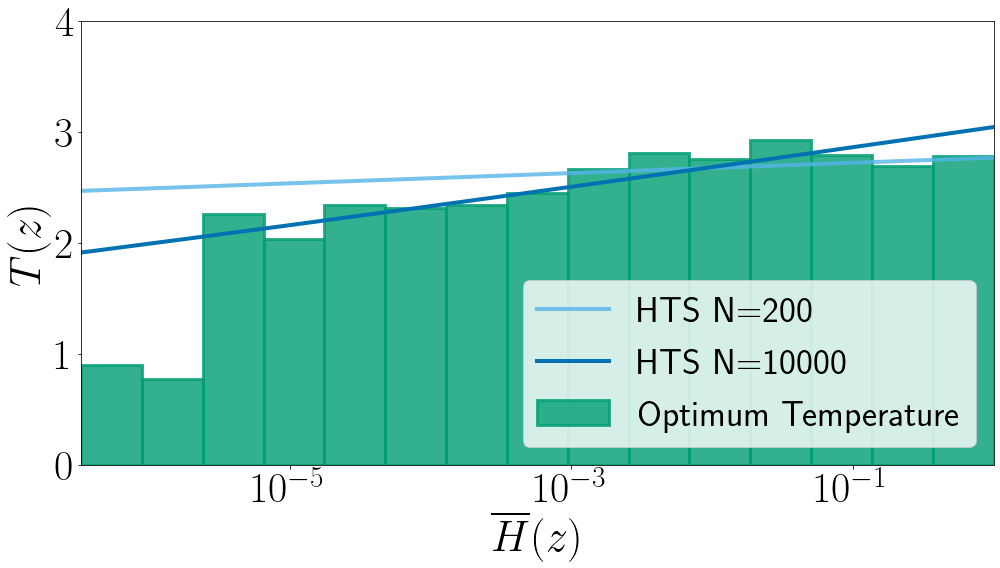

In [57]:
fig, ax = plt.subplots(figsize=(14, 8))

ax.plot(x_axis, HTS2T_tld(x_axis), c=color_palette_J['blue'], lw=4, alpha=0.8, label='HTS N=200')
ax.plot(x_axis, HTS2T_t(x_axis), c=color_palette_J['dark_blue'], lw=4, label='HTS N=10000')
ax.bar(lims[:-1], Ts, width=(lims[1:]-lims[:-1]), align='edge', color=color_palette_J['green'], alpha=0.8, edgecolor=color_palette_J['green'], linewidth=3, label='Optimum Temperature')
ax.set_xlabel('$\overline{H}(z)$', fontsize=44)
ax.set_ylabel('$T(z)$', fontsize=44)

ax.tick_params(axis='both', labelsize=42)
ax.set_xscale('log')
ax.legend(fontsize=36, loc='lower right')
ax.set_xlim(lims[0], 1)
ax.set_ylim(0, 4)

plt.tight_layout()
plt.plot();

# fig.savefig('C:/Users/sergi/Google Drive/PhD/AdaTS/imgsPaper/HTS_entropy.pdf')

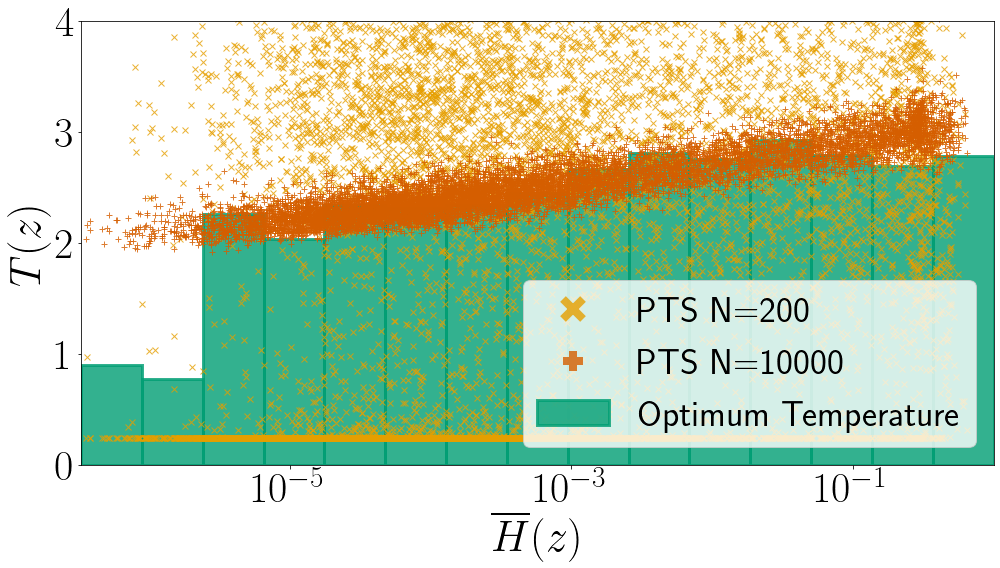

In [58]:
fig, ax = plt.subplots(figsize=(14, 8))


ax.plot(logH_test, ptsld_test, c=color_palette_J['orange'], marker='x', ls='', alpha=0.8, label='PTS N=200')
ax.plot(logH_test, pts_test, c=color_palette_J['dark_orange'], marker='+', ls='', alpha=0.8, label='PTS N=10000')
ax.bar(lims[:-1], Ts, width=(lims[1:]-lims[:-1]), align='edge', color=color_palette_J['green'], alpha=0.8, edgecolor=color_palette_J['green'], linewidth=3, label='Optimum Temperature')
ax.set_xlabel('$\overline{H}(z)$', fontsize=44)
ax.set_ylabel('$T(z)$', fontsize=44)

ax.tick_params(axis='both', labelsize=42)
ax.set_xscale('log')
lgnd = ax.legend(fontsize=36, loc='lower right')
ax.set_xlim(lims[0], 1)
ax.set_ylim(0, 4)

lgnd.legendHandles[0]._legmarker.set_markersize(20)
lgnd.legendHandles[1]._legmarker.set_markersize(20)


lgnd.legendHandles[0]._legmarker.set_markeredgewidth(8)
lgnd.legendHandles[1]._legmarker.set_markeredgewidth(8)

plt.tight_layout()
plt.plot();

# fig.savefig('C:/Users/sergi/Google Drive/PhD/AdaTS/imgsPaper/PTS_entropy.pdf')

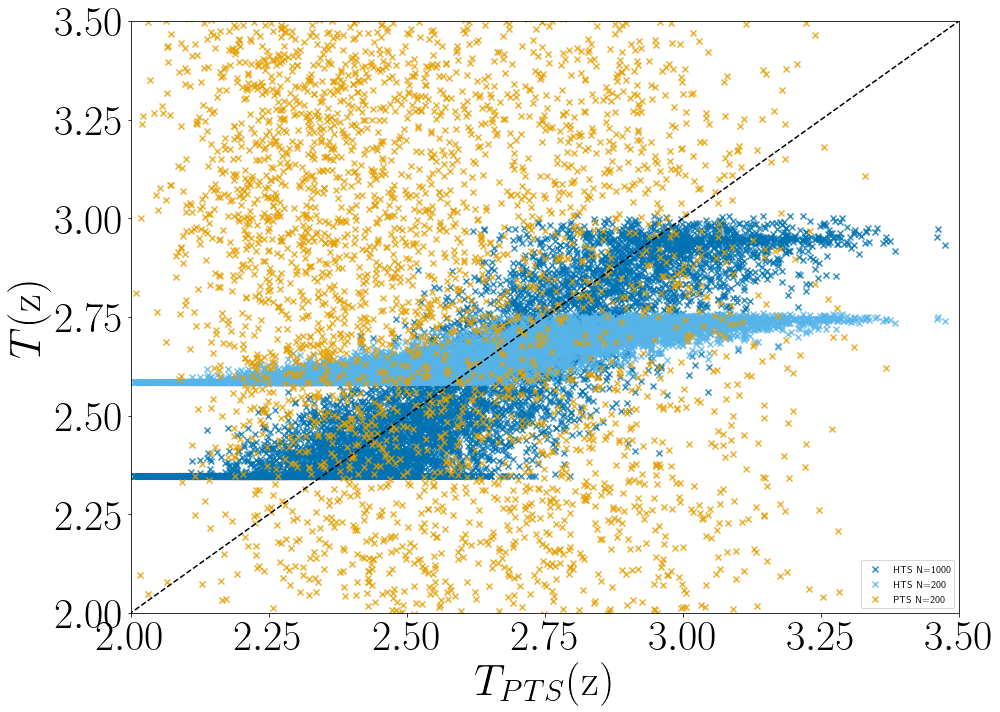

In [66]:
fig, ax = plt.subplots(figsize=(14, 10))


ax.scatter(pts_test, hts_t_test, c=color_palette_J['dark_blue'], marker='x', alpha=0.8, label='HTS N=1000')
ax.scatter(pts_test, hts_tld_test, c=color_palette_J['blue'], marker='x', alpha=0.8, label='HTS N=200')
ax.scatter(pts_test, ptsld_test, c=color_palette_J['orange'], marker='x', alpha=0.8, label='PTS N=200')
ax.plot([0, 4], [0, 4], 'k--')
ax.set_xlabel('$T_{PTS}(\mathrm{z})$', fontsize=44)
ax.set_ylabel('$T(\mathrm{z})$', fontsize=44)

ax.tick_params(axis='both', labelsize=42)
ax.set_ylim(2, 3.5)
ax.set_xlim(2, 3.5)

ax.legend()


plt.tight_layout()
plt.plot();

# fig.savefig('C:/Users/sergi/Google Drive/PhD/AdaTS/imgsPaper/PTS_v_HTS.pdf')

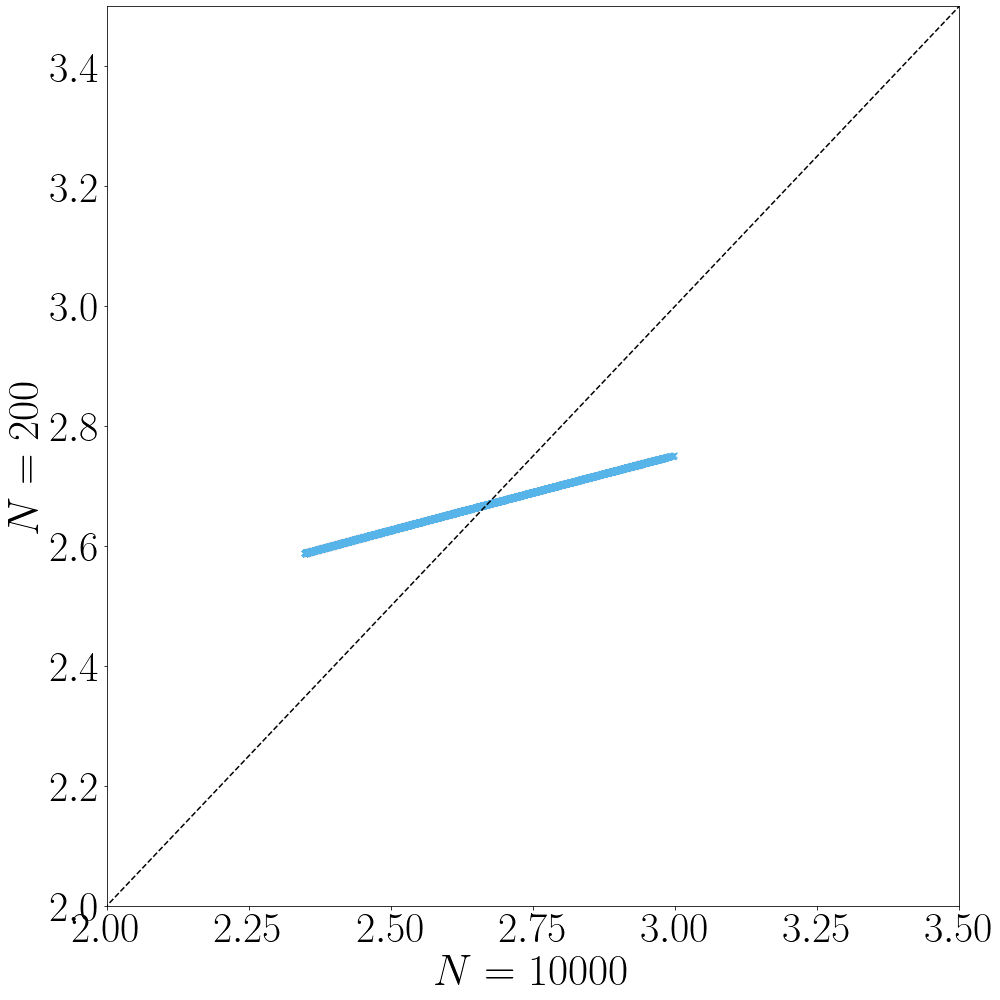

In [64]:
fig, ax = plt.subplots(figsize=(14, 14))


ax.scatter(hts_t_test, hts_tld_test, c=color_palette_J['blue'], marker='x', alpha=0.8)
ax.plot([0, 4], [0, 4], 'k--')
ax.set_xlabel('$N=10000$', fontsize=44)
ax.set_ylabel('$N=200$', fontsize=44)

ax.tick_params(axis='both', labelsize=42)
ax.set_xlim(2, 3.5)
ax.set_ylim(2, 3.5)


plt.tight_layout()
plt.plot();

fig.savefig('C:/Users/sergi/Google Drive/PhD/AdaTS/imgsPaper/HTS_v_HTS.pdf')

In [26]:
# Binarize Data
M = 10
ixs, lims = binByEntropy(Z_train, M=M, mode='log')

## Compute optimum entropy per bin
Ts = np.ones(M)
for i, ix in enumerate(ixs):
    if any(ix):
        try:
            ts_aux = TS(dim)
            ts_aux.fit(Z_train[ix], y_train[ix], v=False);
            Ts[i] = ts_aux.t
        except Exception as e:
            print(e)
            continue

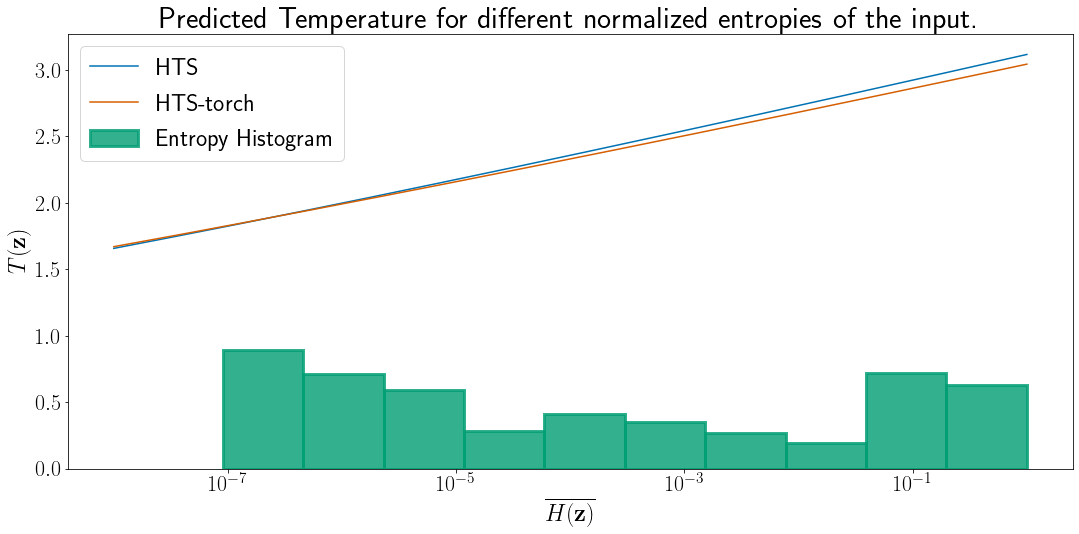

In [27]:
fig, ax = plt.subplots(figsize=(18, 8))

ax.plot(x_axis, HTS2T(x_axis), c=color_palette_J['dark_blue'], label='HTS')
ax.plot(x_axis, HTS2T_t(x_axis), c=color_palette_J['dark_orange'], label='HTS-torch')
ax.bar(lims[:-1], Ts, width=(lims[1:]-lims[:-1]), align='edge', color=color_palette_J['green'], alpha=0.8, edgecolor=color_palette_J['green'], linewidth=3, label='Entropy Histogram')
ax.set_xlabel('$\overline{H(\mathbf{z})}$', fontsize=24)
ax.set_ylabel('$T(\mathbf{z})$', fontsize=24)
ax.set_title('Predicted Temperature for different normalized entropies of the input.', fontsize=30)

ax.tick_params(axis='both', labelsize=22)
ax.set_xscale('log')
ax.legend(fontsize=24)

plt.plot();

### Robustness to low data

In [28]:
trainWR, validationWR, testWR = load_precomputedlogits(dataset='cifar100', model='densenet-121', data_path='../../data')

Z_train, y_train = trainWR
Z_val, y_val = validationWR
Z_test, y_test = testWR

In [29]:
np.random.seed(15)
rnd_ix = np.random.permutation(Z_val.shape[0])[:100]

In [30]:
### Temp-Scal as baseline:
tempScaler = TS(100)
tempScaler.fit(Z_val[rnd_ix], y_val[rnd_ix], v=True);

Optimization terminated successfully.
         Current function value: 72.197054
         Iterations: 4
         Function evaluations: 6
         Gradient evaluations: 6


In [31]:
hts_ld = AdaTS(HTS_torch(100))
hts_ld = fitAdaTS(hts_ld, Z_val[rnd_ix], y_val[rnd_ix], epochs=30000, batch_size=10000, lr=1e-3, v=True, optimizer='sgd')

On epoch: 1434, loss: 7.134e+01, at time: 2.67s
Finish training, convergence reached. Loss: 71.34 



In [32]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScaler.predictive(Z_test),
                             'HTS_torch': hts_ld.predictive(Z_test)}, target=y_test, from_logits=False);

##### Results on test set:
Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal              78.80%         8.72%        22.68%    3.171e-01     8.939e-01
TempScal           78.80%         4.29%        12.73%    3.055e-01     8.360e-01
HTS_torch          78.80%         4.09%        12.46%    3.059e-01     8.259e-01


In [ ]:
for i in range(200, 1000):
    np.random.seed(i)
    rnd_ix = np.random.permutation(Z_val.shape[0])[:100]
    
    hts_ld = AdaTS(HTS_torch(100))
    hts_ld = fitAdaTS(hts_ld, Z_val[rnd_ix], y_val[rnd_ix], epochs=30000, batch_size=10000, lr=1e-3, v=True, optimizer='sgd')
    
    acc, ece, bri, nll, mce = compute_metrics(hts_ld.predictive(Z_test), y_test, M=50, from_logits=False)
    
    print(i)
    print(nll)
    print(hts_ld.modelT.w.item())

On epoch: 1354, loss: 6.861e+01, at time: 2.18s
Finish training, convergence reached. Loss: 68.61 

200
0.83783007
-0.026807580143213272
On epoch: 1664, loss: 8.867e+01, at time: 2.67s
Finish training, convergence reached. Loss: 88.67 

201
0.8293338
-0.13552261888980865
On epoch: 1724, loss: 6.735e+01, at time: 2.75s
Finish training, convergence reached. Loss: 67.35 

202
0.830899
-0.07741355895996094
On epoch: 1364, loss: 8.620e+01, at time: 2.26s
Finish training, convergence reached. Loss: 86.20 

203
0.82625496
-0.10506416857242584
On epoch: 724, loss: 9.417e+01, at time: 1.18s
Finish training, convergence reached. Loss: 94.17 

204
0.83259475
-0.09698409587144852
On epoch: 1134, loss: 9.842e+01, at time: 1.88s
Finish training, convergence reached. Loss: 98.42 

205
0.82989025
-0.05404513701796532
On epoch: 1744, loss: 8.169e+01, at time: 3.03s
Finish training, convergence reached. Loss: 81.69 

206
0.83388
-0.11706175655126572
On epoch: 724, loss: 1.019e+02, at time: 1.26s
Finish 

On epoch: 724, loss: 9.565e+01, at time: 1.26s
Finish training, convergence reached. Loss: 95.65 

261
0.828196
-0.0793391764163971
On epoch: 1554, loss: 6.934e+01, at time: 2.84s
Finish training, convergence reached. Loss: 69.34 

262
0.8332711
-0.010741875506937504
On epoch: 1654, loss: 8.859e+01, at time: 2.99s
Finish training, convergence reached. Loss: 88.59 

263
0.82990575
-0.13733580708503723
On epoch: 1234, loss: 1.252e+02, at time: 2.24s
Finish training, convergence reached. Loss: 125.17 

264
0.83857775
-0.06805027276277542
On epoch: 1154, loss: 9.455e+01, at time: 2.10s
Finish training, convergence reached. Loss: 94.55 

265
0.8272101
-0.09236457198858261
On epoch: 784, loss: 8.583e+01, at time: 1.42s
Finish training, convergence reached. Loss: 85.83 

266
0.8263527
-0.07174674421548843
On epoch: 1504, loss: 8.274e+01, at time: 2.77s
Finish training, convergence reached. Loss: 82.74 

267
0.82542473
-0.08818317204713821
On epoch: 1774, loss: 8.350e+01, at time: 3.26s
Finish

321
0.8254006
-0.08225323259830475
On epoch: 1854, loss: 7.238e+01, at time: 3.42s
Finish training, convergence reached. Loss: 72.38 

322
0.8307575
-0.14334091544151306
On epoch: 1704, loss: 9.461e+01, at time: 3.19s
Finish training, convergence reached. Loss: 94.61 

323
0.8395242
0.014476040378212929
On epoch: 1854, loss: 7.813e+01, at time: 3.56s
Finish training, convergence reached. Loss: 78.13 

324
0.83444256
-0.1417641043663025
On epoch: 734, loss: 1.088e+02, at time: 1.36s
Finish training, convergence reached. Loss: 108.82 

325
0.8272375
-0.04937848821282387
On epoch: 1914, loss: 7.410e+01, at time: 3.37s
Finish training, convergence reached. Loss: 74.10 

326
0.829186
-0.1287260204553604
On epoch: 1204, loss: 8.272e+01, at time: 2.18s
Finish training, convergence reached. Loss: 82.72 

327
0.82942265
-0.05007471889257431
On epoch: 1374, loss: 9.441e+01, at time: 2.53s
Finish training, convergence reached. Loss: 94.41 

328
0.8279532
-0.11277110129594803
On epoch: 1754, loss:

382
0.8275766
-0.06367501616477966
On epoch: 1604, loss: 9.387e+01, at time: 2.83s
Finish training, convergence reached. Loss: 93.87 

383
0.83034
-0.14059820771217346
On epoch: 1404, loss: 9.373e+01, at time: 2.58s
Finish training, convergence reached. Loss: 93.73 

384
0.82540333
-0.09422567486763
On epoch: 1324, loss: 8.876e+01, at time: 2.36s
Finish training, convergence reached. Loss: 88.76 

385
0.82713425
-0.10410900413990021
On epoch: 1304, loss: 1.133e+02, at time: 2.42s
Finish training, convergence reached. Loss: 113.27 

386
0.8369703
-0.13905519247055054
On epoch: 1114, loss: 9.085e+01, at time: 1.98s
Finish training, convergence reached. Loss: 90.85 

387
0.8254824
-0.07297086715698242
On epoch: 814, loss: 8.487e+01, at time: 1.47s
Finish training, convergence reached. Loss: 84.87 

388
0.82704806
-0.05600316449999809
On epoch: 1384, loss: 1.102e+02, at time: 2.55s
Finish training, convergence reached. Loss: 110.23 

389
0.8330626
-0.02254943549633026
On epoch: 804, loss: 

443
0.8296131
-0.1338045448064804
On epoch: 1034, loss: 6.834e+01, at time: 1.86s
Finish training, convergence reached. Loss: 68.34 

444
0.8280498
-0.048320185393095016
On epoch: 834, loss: 7.447e+01, at time: 1.47s
Finish training, convergence reached. Loss: 74.47 

445
0.8359588
-0.017725836485624313
On epoch: 1404, loss: 5.860e+01, at time: 2.54s
Finish training, convergence reached. Loss: 58.60 

446
0.83221924
-0.01591513305902481
On epoch: 884, loss: 5.678e+01, at time: 1.59s
Finish training, convergence reached. Loss: 56.78 

447
0.83652127
-0.016728784888982773
On epoch: 864, loss: 9.661e+01, at time: 1.53s
Finish training, convergence reached. Loss: 96.61 

448
0.826208
-0.07121219485998154
On epoch: 1784, loss: 8.004e+01, at time: 3.19s
Finish training, convergence reached. Loss: 80.04 

449
0.8308361
-0.13546019792556763
On epoch: 1414, loss: 1.105e+02, at time: 2.46s
Finish training, convergence reached. Loss: 110.53 

450
0.842231
-0.06234829127788544
On epoch: 1504, loss

504
0.8256707
-0.10532622784376144
On epoch: 874, loss: 9.058e+01, at time: 1.54s
Finish training, convergence reached. Loss: 90.58 

505
0.82670456
-0.054543040692806244
On epoch: 1574, loss: 7.648e+01, at time: 2.90s
Finish training, convergence reached. Loss: 76.48 

506
0.8274629
-0.08356493711471558
On epoch: 1304, loss: 1.159e+02, at time: 2.39s
Finish training, convergence reached. Loss: 115.95 

507
0.8347037
-0.0513165108859539
On epoch: 1344, loss: 6.645e+01, at time: 2.42s
Finish training, convergence reached. Loss: 66.45 

508
0.8408471
-0.02286296896636486
On epoch: 734, loss: 1.175e+02, at time: 1.38s
Finish training, convergence reached. Loss: 117.55 

509
0.82878244
-0.07880879938602448
On epoch: 1104, loss: 1.085e+02, at time: 1.98s
Finish training, convergence reached. Loss: 108.53 

510
0.8294433
-0.056328579783439636
On epoch: 1734, loss: 7.124e+01, at time: 3.18s
Finish training, convergence reached. Loss: 71.24 

511
0.8301666
-0.13197217881679535
On epoch: 724, l

625
0.83278006
-0.15218064188957214
On epoch: 724, loss: 9.260e+01, at time: 1.37s
Finish training, convergence reached. Loss: 92.60 

626
0.82710207
-0.06697534769773483
On epoch: 834, loss: 8.753e+01, at time: 1.62s
Finish training, convergence reached. Loss: 87.53 

627
0.833808
-0.024070046842098236
On epoch: 1194, loss: 8.363e+01, at time: 2.29s
Finish training, convergence reached. Loss: 83.63 

628
0.8333084
-0.07464411854743958
On epoch: 1544, loss: 8.371e+01, at time: 2.75s
Finish training, convergence reached. Loss: 83.71 

629
0.82655555
-0.1057901531457901
On epoch: 744, loss: 8.494e+01, at time: 1.37s
Finish training, convergence reached. Loss: 84.94 

630
0.8287814
-0.03762415423989296
On epoch: 1344, loss: 7.676e+01, at time: 2.40s
Finish training, convergence reached. Loss: 76.76 

631
0.8268373
-0.06782452762126923
On epoch: 924, loss: 8.640e+01, at time: 1.59s
Finish training, convergence reached. Loss: 86.40 

632
0.83171993
-0.021817386150360107
On epoch: 1334, loss

746
0.8276125
-0.07560625672340393
On epoch: 1254, loss: 9.446e+01, at time: 2.21s
Finish training, convergence reached. Loss: 94.46 

747
0.8292909
-0.10644146800041199
On epoch: 1084, loss: 9.665e+01, at time: 1.94s
Finish training, convergence reached. Loss: 96.65 

748
0.8268275
-0.09257951378822327
On epoch: 1174, loss: 1.088e+02, at time: 2.05s
Finish training, convergence reached. Loss: 108.79 

749
0.8272122
-0.10009760409593582
On epoch: 1274, loss: 1.055e+02, at time: 2.31s
Finish training, convergence reached. Loss: 105.50 

750
0.83405364
-0.0626579225063324
On epoch: 1314, loss: 1.025e+02, at time: 2.38s
Finish training, convergence reached. Loss: 102.46 

751
0.8265604
-0.09955388307571411
On epoch: 2164, loss: 6.130e+01, at time: 3.95s
Finish training, convergence reached. Loss: 61.30 

752
0.84589934
-0.15790560841560364
On epoch: 974, loss: 9.024e+01, at time: 1.70s
Finish training, convergence reached. Loss: 90.24 

753
0.8281016
-0.04432949796319008
On epoch: 724, lo

On epoch: 744, loss: 8.577e+01, at time: 1.21s
Finish training, convergence reached. Loss: 85.77 

868
0.8303135
-0.029841003939509392
On epoch: 1254, loss: 9.890e+01, at time: 2.17s
Finish training, convergence reached. Loss: 98.90 

869
0.82586163
-0.09625476598739624
On epoch: 984, loss: 8.843e+01, at time: 1.79s
Finish training, convergence reached. Loss: 88.43 

870
0.8292746
-0.03304130584001541
On epoch: 1484, loss: 8.343e+01, at time: 2.63s
Finish training, convergence reached. Loss: 83.43 

871
0.8278235
-0.11331751197576523
On epoch: 1724, loss: 8.125e+01, at time: 3.05s
Finish training, convergence reached. Loss: 81.25 

872
0.8284098
-0.12204014509916306
On epoch: 1754, loss: 8.122e+01, at time: 3.02s
Finish training, convergence reached. Loss: 81.22 

873
0.8288281
-0.13241375982761383
On epoch: 1644, loss: 1.015e+02, at time: 3.00s
Finish training, convergence reached. Loss: 101.53 

874
0.84194607
-0.025700028985738754
On epoch: 1434, loss: 8.204e+01, at time: 2.62s
Fini

## Comparison with LENET5: A better calibrated DNN

In [21]:
MODEL_PATH = '../../trained_models/CIFAR10/lenet5'

In [22]:
Z_train = np.load(os.path.join(MODEL_PATH, 'train_logits.npy'))
Z_val = np.load(os.path.join(MODEL_PATH, 'val_logits.npy'))
Z_test = np.load(os.path.join(MODEL_PATH, 'test_logits.npy'))

y_train = np.load(os.path.join(CIFAR10_PATH, 'train_labels.npy'))
y_val = np.load(os.path.join(CIFAR10_PATH, 'val_labels.npy'))
y_test = np.load(os.path.join(CIFAR10_PATH, 'test_labels.npy'))

In [23]:
N, dim = Z_train.shape

In [24]:
### Temp-Scal as baseline:
tempScalerLN5 = TempScaling()
tempScalerLN5.fit(Z_val, y_val, v=True);

haTempScalerLN5 = AdaTS(HbasedT(dim))
haTempScalerLN5 = fitAdaTS(haTempScalerLN5, Z_val, y_val, epochs=10000, batch_size=1000, lr=1e-3, v=True)

lhaTempScalerLN5 = AdaTS(HlogbasedT(dim))
lhaTempScalerLN5 = fitAdaTS(lhaTempScalerLN5, Z_val, y_val, epochs=10000, batch_size=1000, lr=1e-3, v=True)

hisTSLN5 = HistTS()
hisTSLN5.fit(Z_val, y_val)

In [25]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScalerLN5.predictive(Z_train),
                             'EntropyAdaptiveTempScal': haTempScalerLN5.predictive(Z_train),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerLN5.predictive(Z_train),
                             'Entropy Histogram TS': hisTSLN5.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                69.24%         1.38%         2.42%    4.158e-01     8.638e-01
TempScal                             69.24%         2.72%         4.05%    4.166e-01     8.667e-01
EntropyAdaptiveTempScal              69.24%         2.84%         4.49%    4.168e-01     8.667e-01
log-EntropyAdaptiveTempScal          69.24%         2.85%         4.41%    4.168e-01     8.667e-01
Entropy Histogram TS                 48.23%         2.90%         7.22%    5.438e-01     1.344e+00


In [26]:
print('##### Results on val set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScalerLN5.predictive(Z_val),
                             'EntropyAdaptiveTempScal': haTempScalerLN5.predictive(Z_val),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerLN5.predictive(Z_val),
                             'Entropy Histogram TS': hisTSLN5.predictive(Z_val)}, target=y_val, from_logits=False);

##### Results on val set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                66.98%         2.17%        30.74%    4.444e-01     9.427e-01
TempScal                             66.98%         2.23%        40.90%    4.442e-01     9.417e-01
EntropyAdaptiveTempScal              66.98%         1.54%        23.97%    4.441e-01     9.413e-01
log-EntropyAdaptiveTempScal          66.98%         1.52%        31.05%    4.442e-01     9.414e-01
Entropy Histogram TS                 47.52%         3.00%         8.06%    5.534e-01     1.363e+00


In [27]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScalerLN5.predictive(Z_test),
                             'EntropyAdaptiveTempScal': haTempScalerLN5.predictive(Z_test),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerLN5.predictive(Z_test),
                             'Entropy Histogram TS': hisTSLN5.predictive(Z_test)}, target=y_test, from_logits=False);

##### Results on test set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                65.72%         1.61%        18.08%    4.636e-01     9.825e-01
TempScal                             65.72%         0.88%        18.18%    4.632e-01     9.805e-01
EntropyAdaptiveTempScal              65.72%         1.17%        12.63%    4.632e-01     9.803e-01
log-EntropyAdaptiveTempScal          65.72%         1.00%        18.04%    4.632e-01     9.803e-01
Entropy Histogram TS                 45.55%         2.14%         4.09%    5.758e-01     1.414e+00


In [28]:
bLN5, wLN5, tLN5 = haTempScalerLN5.modelT.b.item(), haTempScalerLN5.modelT.w.item(), haTempScalerLN5.modelT.t.item()
lbLN5, lwLN5= lhaTempScalerLN5.modelT.b.item(), lhaTempScalerLN5.modelT.w.item()

def HtoTLN5(h):
    T = (np.tanh(h * wLN5 + bLN5) + 1) * tLN5
    return T

def logHtoTLN5(h):
    T = np.log(np.exp(np.log(h) * lwLN5 + lbLN5) + 1)
    return T

In [29]:
# Binarize Data
M = 15
ixs, limsLN5 = binByEntropy(Z_val, M=M, mode='same')

## Compute optimum entropy per bin
TsLN5 = np.ones(M)
for i, ix in enumerate(ixs):
    if any(ix):
        try:
            ts_aux = TempScaling()
            ts_aux.fit(Z_val[ix], y_val[ix], v=True);
            TsLN5[i] = ts_aux.T.detach().numpy()
        except Exception as e:
            continue

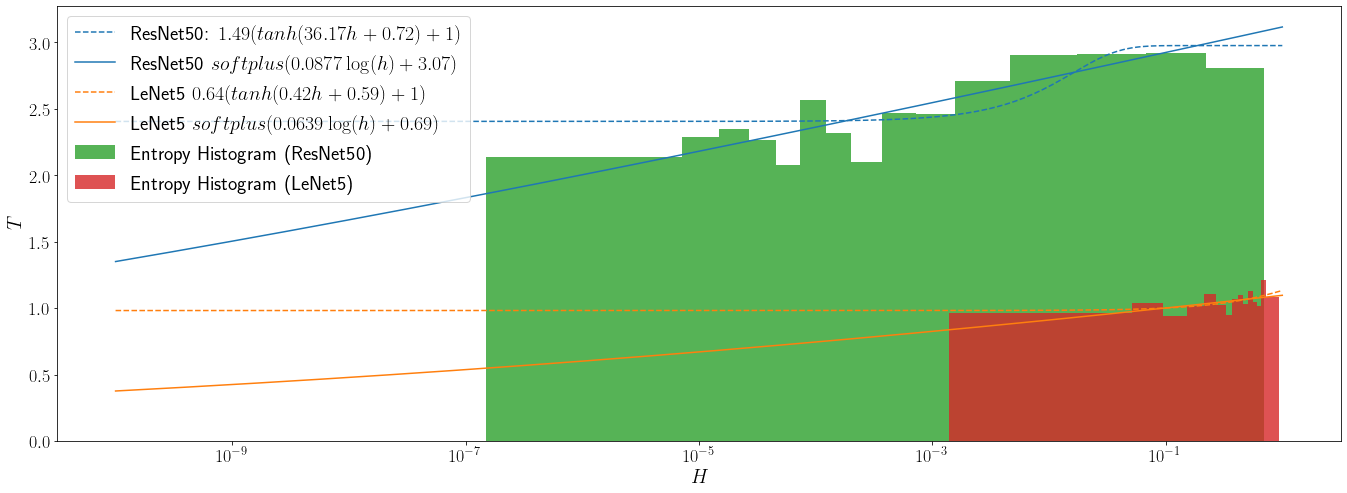

In [30]:
fig, ax = plt.subplots(figsize=(23, 8))

ax.plot(x_axis, HtoT(x_axis), ls='--', c='tab:blue', label='ResNet50: ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(t, w, b))
ax.plot(x_axis, logHtoT(x_axis), ls='-', c='tab:blue', label='ResNet50 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lw, lb))
ax.plot(x_axis, HtoTLN5(x_axis), ls='--', c='tab:orange', label='LeNet5 ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(tLN5, wLN5, bLN5))
ax.plot(x_axis, logHtoTLN5(x_axis), ls='-', c='tab:orange', label='LeNet5 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lwLN5, lbLN5))
ax.bar(lims[:-1], Ts, width=lims[1:]-lims[:-1], align='edge', color='tab:green', alpha=0.8, label='Entropy Histogram (ResNet50)')
ax.bar(limsLN5[:-1], TsLN5, width=limsLN5[1:]-limsLN5[:-1], align='edge', color='tab:red', alpha=0.8, label='Entropy Histogram (LeNet5)')
ax.set_xlabel('$H$', fontsize=20)
ax.set_ylabel('$T$', fontsize=20)

ax.tick_params(axis='both', labelsize=18)
ax.set_xscale('log')
ax.legend(fontsize=20)

plt.plot();

## Comparison with Wide Resnet-28x10: A better calibrated DNN

In [31]:
DATASET = 'cifar10'


trainWR, validationWR, testWR = load_precomputedlogits(dataset=DATASET, model='wide-resnet-28x10', data_path='../../data')

Z_train, y_train = trainWR
Z_val, y_val = validationWR
Z_test, y_test = testWR

In [32]:
### Temp-Scal as baseline:
tempScalerWR = TempScaling()
tempScalerWR.fit(Z_val, y_val, v=True);

haTempScalerWR = AdaTS(HbasedT(dim))
haTempScalerWR = fitAdaTS(haTempScalerWR, Z_val, y_val, epochs=50000, batch_size=1000, lr=1e-4, v=True)

lhaTempScalerWR = AdaTS(HlogbasedT(dim))
lhaTempScalerWR = fitAdaTS(lhaTempScalerWR, Z_val, y_val, epochs=50000, batch_size=1000, lr=1e-4, v=True)

hisTSWR = HistTS()
hisTSWR.fit(Z_val, y_val, M=10)

In [33]:
print('##### Results on train set:')
compare_results(predictions={'Uncal': softmax(Z_train, axis=1),
                             'TempScal': tempScalerWR.predictive(Z_train),
                             'EntropyAdaptiveTempScal': haTempScalerWR.predictive(Z_train),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerWR.predictive(Z_train),
                             'Entropy Histogram TS': hisTSWR.predictive(Z_train)}, target=y_train, from_logits=False);

##### Results on train set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                               100.00%         0.11%        14.28%    1.173e-05     1.102e-03
TempScal                            100.00%         0.89%        22.74%    2.116e-04     9.016e-03
EntropyAdaptiveTempScal             100.00%         0.63%        28.42%    1.895e-04     6.337e-03
log-EntropyAdaptiveTempScal         100.00%         0.70%        28.67%    2.036e-04     7.128e-03
Entropy Histogram TS                100.00%         0.88%        28.45%    3.241e-04     8.931e-03


In [34]:
print('##### Results on val set:')
compare_results(predictions={'Uncal': softmax(Z_val, axis=1),
                             'TempScal': tempScalerWR.predictive(Z_val),
                             'EntropyAdaptiveTempScal': haTempScalerWR.predictive(Z_val),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerWR.predictive(Z_val),
                             'Entropy Histogram TS': hisTSWR.predictive(Z_val)}, target=y_val, from_logits=False, M=50);

##### Results on val set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                95.36%         2.62%        44.71%    7.124e-02     1.562e-01
TempScal                             95.36%         1.65%        37.23%    6.758e-02     1.416e-01
EntropyAdaptiveTempScal              95.36%         1.13%        36.92%    6.691e-02     1.405e-01
log-EntropyAdaptiveTempScal          95.36%         1.23%        37.10%    6.706e-02     1.408e-01
Entropy Histogram TS                 94.58%         1.26%        47.78%    7.163e-02     1.635e-01


In [35]:
print('##### Results on test set:')
compare_results(predictions={'Uncal': softmax(Z_test, axis=1),
                             'TempScal': tempScalerWR.predictive(Z_test),
                             'EntropyAdaptiveTempScal': haTempScalerWR.predictive(Z_test),
                             'log-EntropyAdaptiveTempScal': lhaTempScalerWR.predictive(Z_test),
                             'Entropy Histogram TS': hisTSWR.predictive(Z_test)}, target=y_test, from_logits=False, M=50);

##### Results on test set:
                  Calibrator      Accuracy           ECE           MCE   Brier Score           NLL
Uncal                                96.13%         1.93%        70.70%    6.289e-02     1.497e-01
TempScal                             96.13%         0.70%        74.81%    6.080e-02     1.362e-01
EntropyAdaptiveTempScal              96.13%         0.92%        39.75%    6.070e-02     1.368e-01
log-EntropyAdaptiveTempScal          96.13%         0.73%        39.93%    6.070e-02     1.367e-01
Entropy Histogram TS                 95.30%         0.64%        25.85%    6.599e-02     1.608e-01


In [36]:
bWR, wWR, tWR = haTempScalerWR.modelT.b.item(), haTempScalerWR.modelT.w.item(), haTempScalerWR.modelT.t.item()
lbWR, lwWR= lhaTempScalerWR.modelT.b.item(), lhaTempScalerWR.modelT.w.item()

def HtoTWR(h):
    T = (np.tanh(h * wWR + bWR) + 1) * tWR
    return T

def logHtoTWR(h):
    T = np.log(np.exp(np.log(h) * lwWR + lbWR) + 1)
    return T

In [37]:
# Binarize Data
M = 10
ixs, limsWR = binByEntropy(Z_val, M=M, mode='same')

## Compute optimum entropy per bin
TsWR = np.ones(M)
for i, ix in enumerate(ixs):
    if any(ix):
        try:
            ts_aux = TempScaling()
            ts_aux.fit(Z_val[ix], y_val[ix], v=True);
            TsWR[i] = ts_aux.T.detach().numpy()
        except Exception as e:
            continue

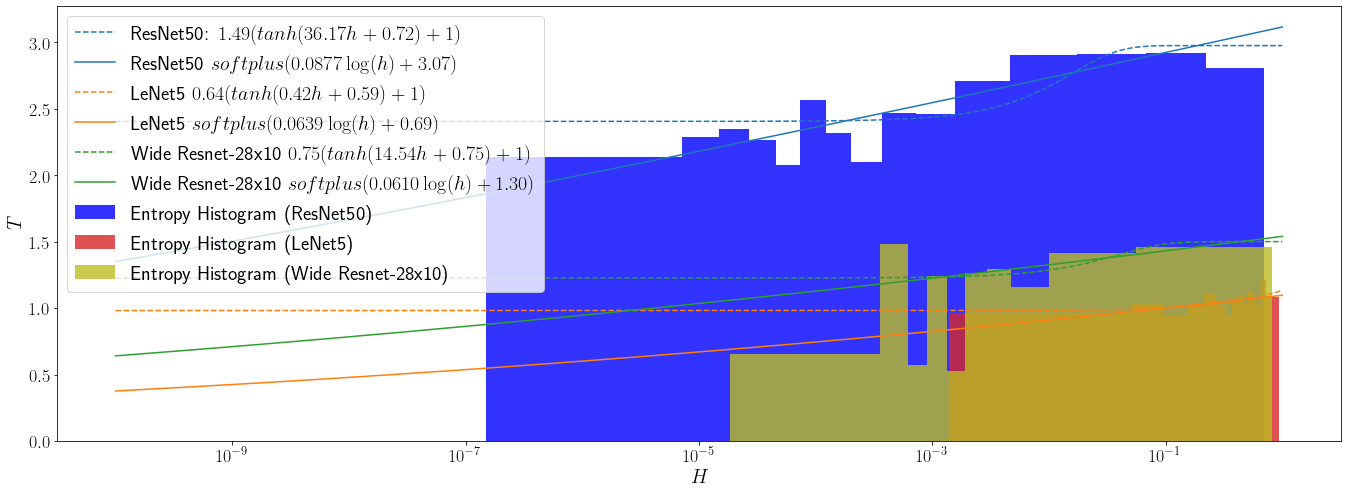

In [38]:
fig, ax = plt.subplots(figsize=(23, 8))

ax.plot(x_axis, HtoT(x_axis), ls='--', c='tab:blue', label='ResNet50: ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(t, w, b))
ax.plot(x_axis, logHtoT(x_axis), ls='-', c='tab:blue', label='ResNet50 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lw, lb))
ax.bar(lims[:-1], Ts, width=lims[1:]-lims[:-1], align='edge', color='blue', alpha=0.8, label='Entropy Histogram (ResNet50)')

ax.plot(x_axis, HtoTLN5(x_axis), ls='--', c='tab:orange', label='LeNet5 ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(tLN5, wLN5, bLN5))
ax.plot(x_axis, logHtoTLN5(x_axis), ls='-', c='tab:orange', label='LeNet5 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lwLN5, lbLN5))
ax.bar(limsLN5[:-1], TsLN5, width=limsLN5[1:]-limsLN5[:-1], align='edge', color='tab:red', alpha=0.8, label='Entropy Histogram (LeNet5)')

ax.plot(x_axis, HtoTWR(x_axis), ls='--', c='tab:green', label='Wide Resnet-28x10 ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(tWR, wWR, bWR))
ax.plot(x_axis, logHtoTWR(x_axis), ls='-', c='tab:green', label='Wide Resnet-28x10 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lwWR, lbWR))
ax.bar(limsWR[:-1], TsWR, width=limsWR[1:]-limsWR[:-1], align='edge', color='tab:olive', alpha=0.8, label='Entropy Histogram (Wide Resnet-28x10)')

ax.set_xlabel('$H$', fontsize=20)
ax.set_ylabel('$T$', fontsize=20)

ax.tick_params(axis='both', labelsize=18)
ax.set_xscale('log')
ax.legend(fontsize=20)

plt.plot();

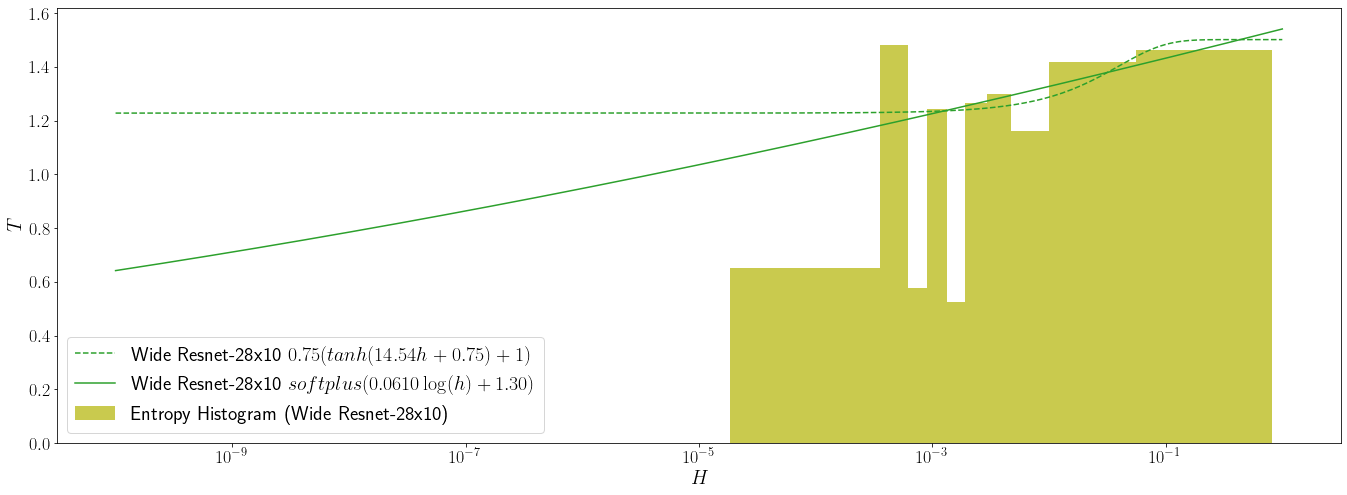

In [39]:
fig, ax = plt.subplots(figsize=(23, 8))


ax.plot(x_axis, HtoTWR(x_axis), ls='--', c='tab:green', label='Wide Resnet-28x10 ${:.2f} (tanh({:.2f}h + {:.2f}) + 1)$'.format(tWR, wWR, bWR))
ax.plot(x_axis, logHtoTWR(x_axis), ls='-', c='tab:green', label='Wide Resnet-28x10 $softplus( {:.4f}\log(h) + {:.2f})$'.format(lwWR, lbWR))
ax.bar(limsWR[:-1], TsWR, width=limsWR[1:]-limsWR[:-1], align='edge', color='tab:olive', alpha=0.8, label='Entropy Histogram (Wide Resnet-28x10)')

ax.set_xlabel('$H$', fontsize=20)
ax.set_ylabel('$T$', fontsize=20)

ax.tick_params(axis='both', labelsize=18)
ax.set_xscale('log')
ax.legend(fontsize=20)

plt.plot();